# Permeability Simulation Using PoreSpy and OpenPNM
This simulation is based on the original notebook [Berea Sandstone Simulation Using PoreSpy and OpenPNM](https://github.com/PMEAL/OpenPNM/blob/master/examples/simulations/Berea%20Sandstone%20-%20Effective%20Permeability.ipynb)

### Start by importing the necessary packages

In [1]:
import numpy as np
import openpnm as op
import porespy as ps
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
np.random.seed(10)
%matplotlib inline

### Load Sandstone Data

In [2]:
resolution = 2.25e-6
name = 'Bentheimer'

In [3]:
# Read input RAW file
raw_file = np.fromfile('Sandstones/'+name+'_2d25um_binary.raw', dtype=np.uint8)
im = (raw_file.reshape(1000,1000,1000))
im = im==0;

### Confirm image and check image porosity


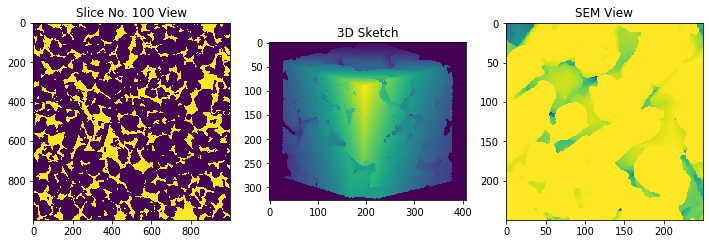

In [7]:
#NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(1, 3, figsize=(12,5))
ax[0].imshow(im[:, :, 100]);
ax[1].imshow(ps.visualization.show_3D(im[:250,:250,:250]));
ax[2].imshow(ps.visualization.sem(im[:250,:250,:250]));
ax[0].set_title("Slice No. 100 View");
ax[1].set_title("3D Sketch");
ax[2].set_title("SEM View");

In [4]:
print(ps.metrics.porosity(im))
print(im.shape)
print(im.dtype)

0.267188596
(1000, 1000, 1000)
bool


### Extract pore network using SNOW algorithm in PoreSpy

The SNOW algorithm (an accronym for Sub-Network from an Oversegmented Watershed) was presented by [Gostick](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.96.023307). 

In [5]:
net = ps.networks.snow(im=im, voxel_size=resolution)

____________________________________________________________
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  58804
Peaks after trimming saddle points:  37258
Peaks after trimming nearby peaks:  36994
____________________________________________________________
Extracting pore and throat information from image


100%|████████████████████████████████████| 41672/41672 [15:06<00:00, 45.95it/s]


### Import network in OpenPNM

The output from the SNOW algorithm above is a plain python dictionary containing all the extracted pore-scale data, but it is NOT yet an OpenPNM network. We need to create an empty network in OpenPNM, then populate it with the data from SNOW:

In [6]:
ws = op.Workspace()
proj = op.Project()
pn = op.network.GenericNetwork(name=name, project=proj)
pn.update(net)  # Fills 'pn' with data from 'net'

## Optional: load already saved network

Now we can print the network to see how the transferred worked:

In [4]:
print(pn)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.network.GenericNetwork : net_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.area                                     36795 / 36795
2     pore.centroid                                 36795 / 36795
3     pore.coords                                   36795 / 36795
4     pore.diameter                                 36795 / 36795
5     pore.equivalent_diameter                      36795 / 36795
6     pore.extended_diameter                        36795 / 36795
7     pore.inscribed_diameter                       36795 / 36795
8     pore.label                                    36795 / 36795
9     pore.surface_area                             36795 / 36795
10    pore.volume                                   36795 / 3679

### Check network health

Remove isolated pores or cluster of pores from the network by checking it network health. Make sure ALL keys in network health functions have no value. 

In [5]:
h = pn.check_network_health()
op.topotools.trim(network=pn, pores=h['trim_pores'])
h = pn.check_network_health()
print(h)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
key                                 value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
disconnected_clusters               []
isolated_pores                      []
trim_pores                          []
duplicate_throats                   []
bidirectional_throats               []
headless_throats                    []
looped_throats                      []
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


### Assign geometry

In [6]:
geo = op.geometry.GenericGeometry(network=pn, pores=pn.Ps, throats=pn.Ts)

### Assign phase

In this example air is considered as fluid passing through porous channels. 

In [7]:
water = op.phases.Water(network=pn)

### Assign physics

In [8]:
phys_water=op.physics.GenericPhysics(network=pn, phase=water, geometry=geo)
R = geo['throat.diameter']/2.0;
L = geo['throat.length'];
phys_water['throat.hydraulic_conductance'] = (np.pi*(R**4))/(8*water['pore.viscosity'].max()*L)

### Calculate effective permeability

Caclulate effective permeablity using hagen poiseuille equation. Use cross section area and flow length manually from image dimension. 

In [9]:
A = (1000*1000) *resolution**2
L = 1000 * resolution
mu = water['pore.viscosity'].max()
Pressure = 10e3;
delta_P = Pressure - 0
#X
perm = op.algorithms.StokesFlow(network=pn, project=proj)
perm.setup(phase=water)
perm.set_value_BC(pores=pn.pores('top'), values=0)
perm.set_value_BC(pores=pn.pores('bottom'), values=Pressure)
perm.run()
Q = perm.rate(pores=pn.pores('bottom'), mode='group')
K = Q * L * mu / (A * delta_P)
print('X:', K/0.98e-12*1000, 'mD')

#y
perm = op.algorithms.StokesFlow(network=pn, project=proj)
perm.setup(phase=water)
perm.set_value_BC(pores=pn.pores('front'), values=0)
perm.set_value_BC(pores=pn.pores('back'), values=Pressure)
perm.run()
Q = perm.rate(pores=pn.pores('back'), mode='group')
K = Q * L * mu / (A * delta_P)
print('Y:', K/0.98e-12*1000, 'mD')

#z
perm = op.algorithms.StokesFlow(network=pn, project=proj)
perm.setup(phase=water)
perm.set_value_BC(pores=pn.pores('left'), values=0)
perm.set_value_BC(pores=pn.pores('right'), values=Pressure)
perm.run()
Q = perm.rate(pores=pn.pores('right'), mode='group')
K = Q * L * mu / (A * delta_P)
print('Z:', K/0.98e-12*1000, 'mD')

X: [999.4799] mD
Y: [976.0905] mD
Z: [960.0699] mD
